# Potential of Monolayer Charge

## Analysis of DFT results

## Import packages

In [1]:
! pip install ase
! pip install matplotlib --upgrade

from ase import Atoms
from ase.db import connect
from ase.io import write, read
from ase.data import atomic_numbers
from os import listdir
import os
from os.path import isfile, join
from sympy import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import re
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MultipleLocator
from collections import defaultdict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 3.5 MB/s eta 0:00:0000:0100:01
  Using cached contourpy-1.0.7-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (299 kB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


## Constants

In [2]:
k = 1.9872041E-3  # kcal/mol/K
rho = 0.03332819694513222
el_chg = 1.60217662e-19 #coulomb
Na = 6.02214129e23
epsilon0 =  8.854187817e-12  #F/m
eps0 = 0.0055263494 # el/V/A
kcal_eV = 2.611448e22  # kcal/(eV)
bohr2a = 0.529177 #A/bohr
D2Cm =  3.33564*10**-30 #C*m
au2D = 2.5417 #D
debye2eAngs = 0.2081943# e*Angs
A2nm=0.1
hartree2V = 27.211386245988
au2ev = 27.211384500

## Functions

In [3]:
def getSurfaceCoverage(area):
  """
  Turn molecule area in Angs2 to surface coverage mol/cm2
  """
  return (1/(area*10**-16))/Na

In [4]:
def potential_at_a(a, z_array, rho_z):
    """Returns poteintial at point a, given a 1D-chg distribution (rho_z) 
    and points at which it was evaluated (z_array) """
    to_integrate = z_array < a
    dz = z_array[1] - z_array[0]
    integrand = 0
    for z_i, rho_zi in zip(z_array[to_integrate], rho_z[to_integrate]):
        integrand += (a - z_i)*rho_zi
    return -1/eps0*integrand*dz

In [5]:
"""
Class to read in data of one surface that corresponds to some optimal distribution of particles on the electrode surface
"""
class SurfaceED:
    def __init__(self, dataRow, calculationType="PW", shift=0):
        
        self.calculationType = calculationType
        #Additions to select right columns
        if calculationType == "LCAO":
          _calcType=["lcao_","lcao_"] #First is how separate components were calculated, second is how the interface was calculated
        elif calculationType == "cDFT":
          _calcType = ["lcao_","cdft_"]
        else:
          _calcType = ["",""]
        
        self.sysName = str(dataRow["electrode"])+"_"+str(dataRow["ads_name"])
        shift = shift #Angs shifting charge density profiles to not have discontinuity
        
        #First get substrate+electrode data
        self.electrodeArea = float(dataRow["area"])

        self.z_Ed=np.array(dataRow["sys_"+_calcType[1]+"den_zax"][1:]).astype(float)
        self.dz_Ed = float(self.z_Ed[2]-self.z_Ed[1]) #Angstroms
        shiftIndex = int(shift//self.dz_Ed)
        self.sysEd = np.array(dataRow["sys_"+_calcType[1]+"den_val"][1:]).astype(float)
        self.sysEd = np.r_[self.sysEd[-shiftIndex:], self.sysEd[:-shiftIndex]]
        
        #Get substrate data
        self.adsEd = np.array(dataRow["ads_"+_calcType[0]+"den_val"][1:]).astype(float)
        self.adsEd = np.r_[self.adsEd[-shiftIndex:], self.adsEd[:-shiftIndex]]
        
        #Get electrode data
        self.metEd = np.array(dataRow["met_"+_calcType[0]+"den_val"][1:]).astype(float)
        self.metEd = np.r_[self.metEd[-shiftIndex:], self.metEd[:-shiftIndex]]
        #Calculate charge density change
        self.chgChange = -(self.sysEd - self.adsEd - self.metEd)
        
        #Calculate potential change 
        self.potentialProfileEdDiff = [potential_at_a(a, self.z_Ed, self.chgChange) for a in self.z_Ed] #V
        self.potDropEdDiff = self.potentialProfileEdDiff[0]-self.potentialProfileEdDiff[-1]
        self.potentialProfileHartree = np.array(dataRow["sys_"+_calcType[1]+"pot_val"][1:]).astype(float) #V
        self.potDropHartree = -(self.potentialProfileHartree[int(len(self.z_Ed)*0.06)]-self.potentialProfileHartree[int(len(self.z_Ed)*0.95)])
        self.z_Hartree = np.array(dataRow["sys_"+_calcType[1]+"pot_zax"][1:]).astype(float)

        #Get data related to electrode positions and molecule positions
        metalIndexes = np.asarray(dataRow.numbers)==atomic_numbers[dataRow.electrode]
        moleculeIndexes = np.asarray(dataRow.numbers)!=atomic_numbers[dataRow.electrode]
        self.metalSheetPositions = np.unique(dataRow.positions[:,2][metalIndexes].round(decimals=4))
        self.moleculeFirstPosition = np.min(dataRow.positions[:,2][moleculeIndexes])
        self.moleculeMeanPosition = np.mean(dataRow.positions[:,2][moleculeIndexes])
        
        #Identifying last layer
        roundedMetalSheetPosition = self.metalSheetPositions.round(0)
        lastLayerRounded = np.unique(roundedMetalSheetPosition)[-1]
        positionsOfLastLayer = self.metalSheetPositions[roundedMetalSheetPosition==lastLayerRounded]
        self.metalSheetLastLayerAveragePosition = np.mean(positionsOfLastLayer)
        self.distanceBetweenElectrodeLayers = self.metalSheetPositions[1]-self.metalSheetPositions[0]
        self.distanceBetweenMetalMoleculeGeometric = self.moleculeMeanPosition - self.metalSheetLastLayerAveragePosition - self.distanceBetweenElectrodeLayers/2


        #Estimate different positions from charge density
        self.metalChargeMaximaPosition = self.estimateMetalChargeMaxima()
        self.metalMoleculeBoundary = self.estimateMetalMoleculeBoundary()

        #Estimate the electrode and molecule charge density
        self.metalCharge = np.sum(self.chgChange[self.z_Ed<self.metalMoleculeBoundary])*self.dz_Ed #e/Å^2
        self.metalCharge = self.metalCharge*el_chg*(10**6)/(10**-16) #μC/cm²
        self.moleculeCharge = np.sum(self.chgChange[self.z_Ed>self.metalMoleculeBoundary])*self.dz_Ed #e/Å^2
        self.moleculeCharge = self.moleculeCharge*el_chg*(10**6)/(10**-16) #μC/cm²

        self.moleculePosition = self.estimateMoleculeLocationFromChargeDensity()
        self.metalChargePlanePosition = self.estimateMetalChargePlane()
        self.distanceBetweenMetalMolecule = self.moleculePosition - self.metalChargePlanePosition



    def estimateMetalChargeMaxima(self):
        #Estimate metal charge maxima plane
        #Limits are the position of last Electrode sheet and half the distance to molecule position
        mask = np.nonzero((self.z_Ed>self.metalSheetPositions[-1]) & (self.z_Ed<0.5*(self.moleculeFirstPosition+self.metalSheetPositions[-1])))[0]
        z_axis_fragment = self.z_Ed[mask]
        chgChange_fragment = self.chgChange[mask]
        #Take absolute value
        chgDensMax = np.argmax(abs(chgChange_fragment))
        metalChargeMaximaPosition = z_axis_fragment[chgDensMax]
        return metalChargeMaximaPosition
    
    def estimateMetalMoleculeBoundary(self):
        #Estimate the position, where the charge is 0 between metal and molecule
        #Limits are the position charge plane and the molecule position
        mask = np.nonzero((self.z_Ed>self.metalChargeMaximaPosition) & (self.z_Ed<self.moleculeFirstPosition))[0]
        z_axis_fragment = self.z_Ed[mask]
        chgChange_fragment = self.chgChange[mask]
        #Take absolute value
        chgDensMax = np.argmin(abs(chgChange_fragment))
        metalMoleculeBoundary = z_axis_fragment[chgDensMax]
        return metalMoleculeBoundary

    def estimateMoleculeLocationFromChargeDensity(self):
        #Estimate the position of molecule by weighted average of charge density
        mask = self.z_Ed>self.metalMoleculeBoundary
        weights = np.abs(self.chgChange[mask])
        weights = weights/np.sum(weights)
        moleculePosition = np.sum(weights*self.z_Ed[mask])
        return moleculePosition

    def estimateMetalChargePlane(self):
        #Estimate the position of metal charge plane by weighted average of charge density
        #First, when summing the charges from right to left, there must be a point, where
        #overall charge is 0, this will be the lower limit of Metal Plane position
        
        reverseChgChange = self.chgChange[::-1]
        reverseZ = self.z_Ed[::-1]
        #Check the charge you expect
        isMoleculeNegative = self.moleculeCharge < 0
        #Set molecule side always positive
        if isMoleculeNegative:
          reverseChgChange=-reverseChgChange
        
        cumulativeCharge = 0
        metalChargePlaneLowerLimit = 0
        for i in range(len(reverseZ)):
          cumulativeCharge+=reverseChgChange[i]
          if(reverseZ[i]<self.metalMoleculeBoundary and cumulativeCharge<0):
            metalChargePlaneLowerLimit = reverseZ[i]
            break

        #Now estimating the molecule charge plane by taking the weighted average
        #of chgDensity between found lower limit and metal molecule boundary
        mask = np.nonzero((self.z_Ed>metalChargePlaneLowerLimit) & (self.z_Ed<self.metalMoleculeBoundary))[0]
        z_axis_fragment = self.z_Ed[mask]
        chgChange_fragment = self.chgChange[mask]
        weights = np.abs(chgChange_fragment)
        weights = weights/np.sum(weights)
        metalPosition = np.sum(weights*z_axis_fragment)
        return metalPosition        



In [6]:
"""
Class to read in data of one system
"""
class SurfaceDDECAnalysis:
    def __init__(self, dataRow, calculationType="PW", shift=0):

        self.calculationType = calculationType
        #Additions to select right columns
        if calculationType == "LCAO":
          _calcType= "lcao_"
        elif calculationType == "cDFT":
          _calcType = "cdft_"
        else:
          _calcType = ""

        self.sysName = str(dataRow.electrode)+"_"+str(dataRow.ads_name)
        shift = shift #Angs shifting charge density profiles to avoid discontinuity

        ## Estimate electrode charge density
        charges = dataRow["sys_"+_calcType+"chg_val"]
        self.electrodeArea = float(dataRow.area)
        self.metalIndexes = np.asarray(dataRow.numbers)==atomic_numbers[dataRow.electrode]
        metCharges = np.array(charges)[self.metalIndexes]
        self.electrodeChargeDensity = np.sum(metCharges)/self.electrodeArea #e/Å
        self.electrodeChargeDensity = self.electrodeChargeDensity*el_chg*(10**6)/(10**-16) #μC/cm²

        ## Estimate potential profile
        zCoords = dataRow.positions[:,2]
        self.bin_size=0.01 #A
        ##Order atoms according to their z-coordinate 
        snap_z_sort=[]
        snap_c_sort=[]
        snap_k_sort=[]
        indexes=np.argsort(zCoords)
        for index in indexes:
            snap_z_sort+=[zCoords[index]]
            snap_c_sort+=[charges[index]]

        ##Divide charges of atoms into bins to get charge density
        z_bin=np.arange(0, 60, self.bin_size)
        c_b=[0]*len(z_bin)
        for l in range(len(snap_z_sort)):
            c_b[int(snap_z_sort[l]//self.bin_size)]+=snap_c_sort[l]

        self.chgDensityDDEC = np.asarray(c_b)/(self.bin_size*self.electrodeArea) #e/Å³ #Divide charges by bin size to get charge density
        self.z_bin = z_bin
        self.potentialDDEC = [potential_at_a(a, self.z_bin, self.chgDensityDDEC) for a in self.z_bin] #V
        self.potDropDDEC = self.potentialDDEC[0]-self.potentialDDEC[-1] #V

## Matplotlib settings

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'

plt.rc('font',        size=10)  # controls default text sizes
plt.rc('axes',   titlesize=10)  # fontsize of the axes title
plt.rc('axes',   labelsize=9)   # fontsize of the x and y labels
plt.rc('xtick',  labelsize=8)   # fontsize of the tick labels
plt.rc('ytick',  labelsize=8)   # fontsize of the tick labels
plt.rc('legend', fontsize =8)   # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title
plt.rc('figure', facecolor='w') # white background

### Color and shape data

In [8]:
colorDict = defaultdict(lambda: "black")
colorDict["N"] = "blue"
colorDict["S"] = "yellow"
colorDict["O"] = "red"

## Mount drive

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/TartuPorto/DATA/IONS-PSC-PRL'
path = './'

In [11]:
# Connect an ASE database with all results
db = connect(os.path.join(path,'pmc8.db'))

In [12]:
# Convert the data into a panda dataframe
columnNames = ['version',
              'electrode',
              'ads_name',
              'ads_enrg',
              'ads_disp',
              'ads_chg',
              'ads_dist',
              'area',
              'face',
              'mode',
              'size',
              'sigma',
              'numbers',
              'positions',
              'sys_chg_val',
              'sys_dip_val',
              'sys_pot_zax',
              'sys_pot_val',
              'sys_den_zax',
              'sys_den_val',
              'ads_den_zax',
              'ads_den_val',
              'met_den_zax',
              'met_den_val',
              'sys_lcao_chg_val',
              'sys_lcao_dip_val',
              'sys_lcao_pot_zax',
              'sys_lcao_pot_val',
              'sys_lcao_den_zax',
              'sys_lcao_den_val',
              'ads_lcao_den_zax',
              'ads_lcao_den_val',
              'met_lcao_den_zax',
              'met_lcao_den_val',
              'sys_cdft_chg_val',
              'sys_cdft_dip_val',
              'sys_cdft_pot_zax',
              'sys_cdft_pot_val',
              'sys_cdft_den_zax',
              'sys_cdft_den_val',
            ]

rdf  = pd.DataFrame(columns=columnNames)

for row in db.select():
    dt = pd.DataFrame(columns=columnNames,
                      data=[[row.version,
                             row.electrode,
                             row.ads_name,
                             row.ads_enrg,
                             row.ads_disp,
                             row.ads_chg,
                             row.ads_dist,
                             row.area,
                             row.face,
                             row.mode,
                             row.size,
                             row.sigma,
                             row.numbers,
                             row.positions,
                             row.data.sys_chg_val,
                             row.data.sys_dip_val,
                             row.data.sys_pot_zax,
                             row.data.sys_pot_val,
                             row.data.sys_den_zax,
                             row.data.sys_den_val,
                             row.data.ads_den_zax,
                             row.data.ads_den_val,
                             row.data.met_den_zax,
                             row.data.met_den_val,
                             row.data.sys_lcao_chg_val,
                             row.data.sys_lcao_dip_val,
                             row.data.sys_lcao_pot_zax,
                             row.data.sys_lcao_pot_val,
                             row.data.sys_lcao_den_zax,
                             row.data.sys_lcao_den_val,
                             row.data.ads_lcao_den_zax,
                             row.data.ads_lcao_den_val,
                             row.data.met_lcao_den_zax,
                             row.data.met_lcao_den_val,
                             row.data.sys_cdft_chg_val,
                             row.data.sys_cdft_dip_val,
                             row.data.sys_cdft_pot_zax,
                             row.data.sys_cdft_pot_val,
                             row.data.sys_cdft_den_zax,
                             row.data.sys_cdft_den_val,
                            ]])
    rdf = pd.concat([rdf, dt], ignore_index=True)

In [13]:
rdf

,version,electrode,ads_name,ads_enrg,ads_disp,ads_chg,ads_dist,area,face,mode,...,ads_lcao_den_zax,ads_lcao_den_val,met_lcao_den_zax,met_lcao_den_val,sys_cdft_chg_val,sys_cdft_dip_val,sys_cdft_pot_zax,sys_cdft_pot_val,sys_cdft_den_zax,sys_cdft_den_val
0,a,Au,C5N,-1.12,-0.82,0.568,2.9,66.09,fcc111,PW,...,"[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.010574, -0.013575, -0.01323, -0.014091, -0...","[-0.119266, -0.115112, -0.115232, -0.114678, -...","[0.091, 0.182, 0.273, 0.364, 0.454999999999999...","[2.7572299264265507, 2.757229480706091, 2.7572...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,a,Au,C19O3v,-0.115,-2.22,0.484,3.14,117.5,fcc111,PW,...,"[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.036335, -0.039491, -0.009884, -0.011074, -...","[-0.164757, -0.162379, -0.11704, -0.116641, -0...","[0.091, 0.182, 0.273, 0.364, 0.454999999999999...","[1.5121774191639776, 1.5121771747126214, 1.512...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,a,Au,C19N3v,-0.967,-2.392,0.707,3.08,117.5,fcc111,PW,...,"[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.058961, -0.047015, -0.00791, -0.023353, -0...","[-0.206343, -0.177474, -0.113878, -0.139782, -...","[0.091, 0.182, 0.273, 0.364, 0.454999999999999...","[1.3352875348058522, 1.3352873189496604, 1.335...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,a,Au,C19N2Ov,-0.657,-2.34,0.669,3.08,117.5,fcc111,PW,...,"[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.035053, -0.024583, -0.009955, -0.024212, -...","[-0.164229, -0.137612, -0.114473, -0.137932, -...","[0.091, 0.182, 0.273, 0.364, 0.454999999999999...","[1.3457037466871309, 1.345703529147082, 1.3457...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,a,Au,C23N,-0.506,-2.498,0.634,3.18,117.5,fcc111,PW,...,"[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.011597, -0.012592, -0.011897, -0.01151, -0...","[-0.119665, -0.118003, -0.118618, -0.1198, -0....","[0.091, 0.182, 0.273, 0.364, 0.454999999999999...","[1.4507972738779498, 1.4507970393489984, 1.450...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,a,Au,C53N,-0.07,-5.438,0.914,3.15,264.37,fcc111,PW,...,"[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.034409, -0.018307, -0.012476, -0.013182, -...","[-0.151464, -0.133229, -0.11765, -0.117465, -0...","[0.091, 0.182, 0.273, 0.364, 0.454999999999999...","[0.5935904256941208, 0.5935903297370301, 0.593...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,a,Au,C95N,7.46,-9.362,1.118,3.16,359.84,fcc111,PW,...,"[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0909999590729343, 0.1819999181458687, 0.272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.012195, -0.01341

In [14]:
systems = []
for i in range(len(rdf)):
  for calcType in ["PW", "LCAO", "cDFT"]:
    systems+=[SurfaceED(rdf.iloc[i], calculationType=calcType)] 

In [ ]:
systemsDDEC = []
for i in range(len(rdf)):
  for calcType in ["PW", "LCAO", "cDFT"]:
    systemsDDEC+=[SurfaceDDECAnalysis(rdf.iloc[i], calculationType=calcType)] 

In [ ]:
#Estimate potential drops for charge differences and Hartree
df = pd.DataFrame()

potDropsEdDiff = [system.potDropEdDiff for system in systems]
potDropsHartree = [system.potDropHartree for system in systems]
sigmas = [system.metalCharge for system in systems]
distances = [system.distanceBetweenMetalMolecule for system in systems]
distancesGeometric = [system.distanceBetweenMetalMoleculeGeometric for system in systems]
heteroAtoms = [re.sub("[^NOS]", "", system.sysName) for system in systems]
sysNames = [system.sysName for system in systems]
calcTypes = [system.calculationType for system in systems]
areas = [system.electrodeArea for system in systems]

#Grab also DDEC data
sigmasDDEC =  [system.electrodeChargeDensity for system in systemsDDEC]
potDropsDDEC = [system.potDropDDEC for system in systemsDDEC]

df["sysName"] = sysNames
df["calcType"] = calcTypes
df["potDropHartree"] = potDropsHartree
df["potDropEdDiff"] = potDropsEdDiff
df["potDropDDEC"] = potDropsDDEC
df["sigma"] = sigmas
df["sigma[e]"] = np.array(sigmas)*np.array(areas)/el_chg/(10**6)*(10**-16)
df["sigmaDDEC"] = sigmasDDEC
df["sigmaDDEC[e]"] = np.array(sigmasDDEC)*np.array(areas)/el_chg/(10**6)*(10**-16)
df["distance"] = distances
df["distanceGeometric"] = distancesGeometric
df["coverage"] = [getSurfaceCoverage(system.electrodeArea) for system in systems]
df["heteroAtom"] = heteroAtoms

In [ ]:
df

In [ ]:
####This table here is for electron density difference values

dfTable = pd.DataFrame()

selectionPW = df[df["calcType"]=="PW"]
selectionCDFT = df[df["calcType"]=="cDFT"]

dfTable["Compound"] = selectionPW.sysName.values
dfTable["varphi"] = selectionPW.potDropEdDiff.values
dfTable["varphi_cDFT"] = selectionCDFT.potDropEdDiff.values
dfTable["sigma"] = selectionPW.sigma.values
dfTable["sigma_cDFT"] = selectionCDFT.sigma.values
dfTable["q_ion[e]"] = -selectionPW["sigma[e]"].values
dfTable["q_ion_cDFT[e]"] = -selectionCDFT["sigma[e]"].values
dfTable["l"] = selectionPW.distance.values
dfTable["d"] = selectionPW.distanceGeometric.values
dfTable = dfTable.sort_values(by="varphi", ascending=False)

In [ ]:
dfTable

In [ ]:
####This table here is for DDEC values

dfTable2 = pd.DataFrame()
selectionPW = df[df["calcType"]=="PW"]
selectionCDFT = df[df["calcType"]=="cDFT"]
dfTable2["Compound"] = selectionPW.sysName.values
dfTable2["varphi"] = selectionPW.potDropDDEC.values
dfTable2["varphi_cDFT"] = selectionCDFT.potDropDDEC.values
dfTable2["sigma"] = selectionPW.sigmaDDEC.values
dfTable2["sigma_cDFT"] = selectionCDFT.sigmaDDEC.values
dfTable2["q_ion[e]"] = -selectionPW["sigmaDDEC[e]"].values
dfTable2["q_ion[e]_cDFT"] = -selectionCDFT["sigmaDDEC[e]"].values
dfTable2 = dfTable2.sort_values(by="varphi", ascending=False)
dfTable2

## Figure illustrating the location of metal-molecule boundary

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.33, 3.33), dpi=100)
sysIndex = 0
print(systems[sysIndex].sysName)
ax.plot(systems[sysIndex].z_Ed/10, systems[sysIndex].chgChange*1000, color="k", lw=2)
ax.plot(systems[sysIndex].z_Ed/10, systems[sysIndex].chgChange*1000, color="k", lw=2)

ax.axvline(systems[sysIndex].metalMoleculeBoundary/10, color="blue", ls="--")
ax.set_xlabel(r"distance, $z$ / nm", fontsize=10)
ax.set_ylabel(r"charge density difference, $\Delta\rho$ / e$\cdot$nm$^{-3}$", fontsize=10)


ax.set_xlim(0.5, 2.5)
x_labels = np.arange(0.5, 2.6, 1)
ax.set_xticks(x_labels)
ax.set_xticklabels((x_labels-min(x_labels)).round(0).astype(int))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

ax.set_ylim(-8, 8)
y_labels = np.arange(-8, 9, 4)
ax.set_yticks(y_labels)
ax.yaxis.set_minor_locator(MultipleLocator(2))

ax.tick_params(axis="both", which="both", labelsize=8)
#fig.savefig(os.path.join(path,"deltaRho-vs-distance.svg"))

## Fitting Linear model to sigma × distance vs potential drop

In [ ]:
df_PW = df[df["calcType"] == "PW"]

In [ ]:
distanceTimesSigma = df_PW["sigma"].values*df_PW["distance"].values

print("From WF potential")

ols_WF = LinearRegression(fit_intercept=False)
ols_WF.fit(distanceTimesSigma.reshape(-1,1), df_PW["potDropHartree"])
print('R2 %3.3f ' % (ols_WF.score(distanceTimesSigma.reshape(-1,1), df_PW["potDropHartree"])))

#Fit two point for line illustration
X_test = np.asarray([-60,0]).reshape(-1,1)
y_test = ols_WF.predict(X_test)

ols_coef_WF = ols_WF.coef_[0]
print(f"Incline: {ols_coef_WF}")

epsilon_estimated_WF = 1/(ols_coef_WF*1.602*10**3) #e/V/Angs
print(f"Estimated epsilon: {epsilon_estimated_WF} e/(V*Angs)")
print(f"eps_estimated/eps0 {epsilon_estimated_WF/eps0}")

In [24]:
ols_ChgDiff = LinearRegression(fit_intercept=False)
ols_ChgDiff.fit(distanceTimesSigma.reshape(-1,1), df_PW["potDropEdDiff"])
print("From Charge difference potential")

print('R2 %3.3f ' % (ols_ChgDiff.score(distanceTimesSigma.reshape(-1,1), df_PW["potDropEdDiff"])))

#Fit two point for line illustration
X_test = np.asarray([-60,0]).reshape(-1,1)
y_test = ols_ChgDiff.predict(X_test)

ols_coef_ChgDiff = ols_ChgDiff.coef_[0]
print(f"Incline: {ols_coef_ChgDiff}")
epsilon_estimated_ChgDiff = 1/(ols_coef_ChgDiff*1.602*10**3) #e/V/Angs
print(f"Estimated epsilon: {epsilon_estimated_ChgDiff} e/(V*Angs)")
print(f"eps_estimated/eps0 {epsilon_estimated_ChgDiff/eps0}")

From Charge difference potential
R2 0.993 
Incline: 0.11271581696807884
Estimated epsilon: 0.0055379958388635025 e/(V*Angs)
eps_estimated/eps0 1.0021074380247297


### Figure illustrating charge density × distance vs potential drop

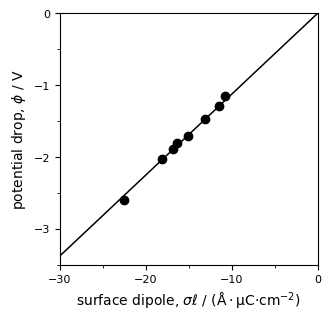

In [29]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(3.33, 3.33), dpi=100)
ax1.plot(df_PW["sigma"].values*df_PW["distance"].values, df_PW["potDropEdDiff"], 'o', markerfacecolor="k", markeredgecolor="k",  label=r'$\Delta \rho$')
ax1.plot(X_test, y_test, color="k", ls="-", lw=1.1, label="Fitted line")
ax1.set_xlabel(r"surface dipole, $\sigma \ell$ / ($\mathrm{\AA} \cdot \mathrm{\mu}$C$\cdot$cm$^{-2}$)", fontsize=10)
ax1.set_ylabel(r"potential drop, $\phi$ / V", fontsize=10)
ax1.set_xlim(-30,0)
ax1.set_ylim(-3.5, 0)
ax1.set_xticks(np.arange(-30, 1, 10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.set_yticks(np.arange(-3.0, 0.1, 1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.tick_params(axis="both", which="both", labelsize=8)
